In [1]:
import glob
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

from datetime import datetime
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator
from notebook_utils import configure_path, setup_matplotlib

In [2]:
setup_matplotlib()
configure_path()

## CANTV's connectivity

Given CANTV’s prominent position, we examine the network’s upstream and downstream connectivity over time.

In [3]:
def download_delegated_lacnic_data(date, filename):
    date_str = date.strftime("%Y%m%d")
    url = "https://ftp.lacnic.net/pub/stats/lacnic/delegated-lacnic-{}".format(date_str)

    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"File downloaded successfully: {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

In [4]:
def parse_delegated_lacnic_data(start_date, end_date, download_files=False):
    delve = []
    date = start_date

    while date < end_date:
        date_str = date.strftime("%Y%m%d")
        url = "https://ftp.lacnic.net/pub/stats/lacnic/delegated-lacnic-{}".format(
            date_str
        )
        filename = "data/raw/08-delegated-lacnic/{}".format(url.split("/")[-1])

        if download_files:
            download_delegated_lacnic_data(date, filename)

        if os.path.exists(filename):
            delfile = pd.read_csv(
                filename,
                sep="|",
                skiprows=4,
                names=["rir", "cc", "type", "asn", "cnt", "date", "status", "hash"],
            )

            delasn_ve = delfile.loc[
                (delfile["type"] == "asn") & (delfile["cc"] == "VE")
            ]

            delve.append((date, delasn_ve.shape[0]))

        date += relativedelta(months=+1)

    return delve

In [5]:
DOWNLOAD_FILES = False
START_DATE = datetime(2003, 1, 1)
END_DATE = datetime.today()

delve = parse_delegated_lacnic_data(START_DATE, END_DATE, DOWNLOAD_FILES)

In [6]:
delve = pd.DataFrame(delve, columns=["date", "cnt"])

In [7]:
delve.tail()

,date,cnt
241,2024-03-01,206
242,2024-04-01,209
243,2024-05-01,214
244,2024-06-01,216
245,2024-07-01,219


In [8]:
def get_date_from_asrel_filename(asrel_filename):
    return datetime.strptime(asrel_filename.split("/")[-1].split(".")[0], "%Y%m%d")

In [9]:
def generate_asrel_for_asns_df(asns, group_by=None, count_by=None):
    df = pd.DataFrame()

    # probably https://www.caida.org/catalog/datasets/as-relationships/
    for filename in glob.glob("data/raw/08-asrel/*"):
        date = get_date_from_asrel_filename(filename)

        tmp = pd.read_csv(
            filename,
            sep="|",
            comment="#",
            compression="bz2",
            names=["provider", "customer", "type"],
        )

        tmp = tmp.loc[(tmp[group_by].isin(asns)) & (tmp["type"] == -1)]

        if count_by:
            tmp = tmp.groupby(group_by)[count_by].count().reset_index()

        tmp["date"] = np.repeat(date, tmp.shape[0])

        df = pd.concat([df, tmp])

    df = df.sort_values("date")
    return df

In [10]:
cantv_movilnet_asrel_upstream_count_df = generate_asrel_for_asns_df(
    [8048, 27889], "customer", "provider"
)

In [11]:
cantv_movilnet_asrel_upstream_count_df.tail()

,customer,provider,date
0,8048,7,2023-10-01
1,27889,2,2023-11-01
0,8048,7,2023-11-01
1,27889,2,2023-12-01
0,8048,6,2023-12-01


In [12]:
cantv_movilnet_asrel_downstream_count_df = generate_asrel_for_asns_df(
    [8048, 27889], "provider", "customer"
)

In [13]:
cantv_movilnet_asrel_downstream_count_df.tail()

,provider,customer,date
0,8048,21,2023-08-01
0,8048,22,2023-09-01
0,8048,21,2023-10-01
0,8048,21,2023-11-01
0,8048,20,2023-12-01


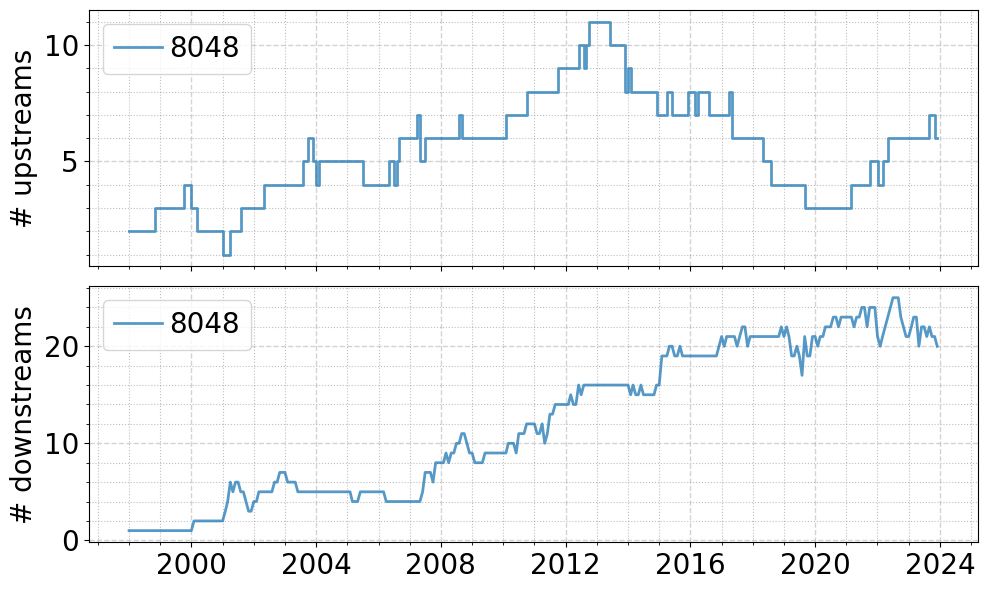

In [14]:
fig, [ax1, ax2] = plt.subplots(2, figsize=(10, 6), sharex=True)

ax1.plot_date(
    cantv_movilnet_asrel_upstream_count_df.loc[
        cantv_movilnet_asrel_upstream_count_df["customer"] == 8048
    ]["date"],
    cantv_movilnet_asrel_upstream_count_df.loc[
        cantv_movilnet_asrel_upstream_count_df["customer"] == 8048
    ]["provider"],
    label="8048",
    xdate=True,
    ydate=False,
    tz="UTC",
    alpha=0.75,
    lw=2,
    fmt="-",
    marker="None",
    drawstyle="steps-pre",
)

ax1.set_ylabel("# upstreams", fontsize=20)
ax1.tick_params(labelsize=20)
ax1.legend(
    loc="upper left",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax1.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax1.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax1.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax1.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

##########
ax2.plot_date(
    cantv_movilnet_asrel_downstream_count_df.loc[
        cantv_movilnet_asrel_downstream_count_df["provider"] == 8048
    ]["date"],
    cantv_movilnet_asrel_downstream_count_df.loc[
        cantv_movilnet_asrel_downstream_count_df["provider"] == 8048
    ]["customer"],
    label="8048",
    xdate=True,
    ydate=False,
    tz="UTC",
    alpha=0.75,
    lw=2,
    fmt="-",
    marker="None",
)

ax2.set_ylabel("# downstreams", fontsize=20)
ax2.tick_params(labelsize=20)
ax2.legend(
    loc="upper left",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax2.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax2.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax2.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax2.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/08-cantv_upstreams_downstreams.pdf")

 Focusing on CANTV’s upstream connectivity, we observe a steady increase until 2013, when there are 11 upstream providers. Subsequently, there was a decline to 3 providers in 2020, followed by a recent rebound. The sustained decline between 2013 and 2020 temporally correlates with Venezuela’s economic implosion and numerous sanctions on the country.

During this period, CANTV significantly expanded its presence in the domestic transit market. Since its nationalization in 2007, the company has consistently grown its customer base, mostly with academic institutions and local banks.

In [15]:
cantv_providers_df = generate_asrel_for_asns_df([8048], "customer")
cantv_downstream_count_df = (
    cantv_providers_df.groupby("provider")["customer"].count().reset_index()
)

In [16]:
cantv_downstream_count_df.tail()

,provider,customer
18,23520,160
19,28007,25
20,52320,131
21,262589,19
22,394684,3


In [17]:
TH = 12
prevalent_cantv_providers = cantv_downstream_count_df.loc[
    cantv_downstream_count_df["customer"] > TH
]["provider"]

In [18]:
set(prevalent_cantv_providers)

{701,
 1239,
 1299,
 3257,
 3356,
 3549,
 4004,
 4436,
 5511,
 6762,
 7018,
 7927,
 12956,
 19962,
 23520,
 28007,
 52320,
 262589}

In [19]:
cantv_providers_df

,provider,customer,type,date
4313,4004,8048,-1,1998-01-01
5336,6541,8048,-1,1998-01-01
5605,6541,8048,-1,1998-02-01
4505,4004,8048,-1,1998-02-01
5760,6541,8048,-1,1998-03-01
...,...,...,...,...
10493,6762,8048,-1,2023-12-01
10494,5511,8048,-1,2023-12-01
10497,23520,8048,-1,2023-12-01
10496,262589,8048,-1,2023-12-01


/tmp/ipykernel_159626/2269324881.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cantv_providers_df["p"] = np.ones(cantv_providers_df.shape[0])


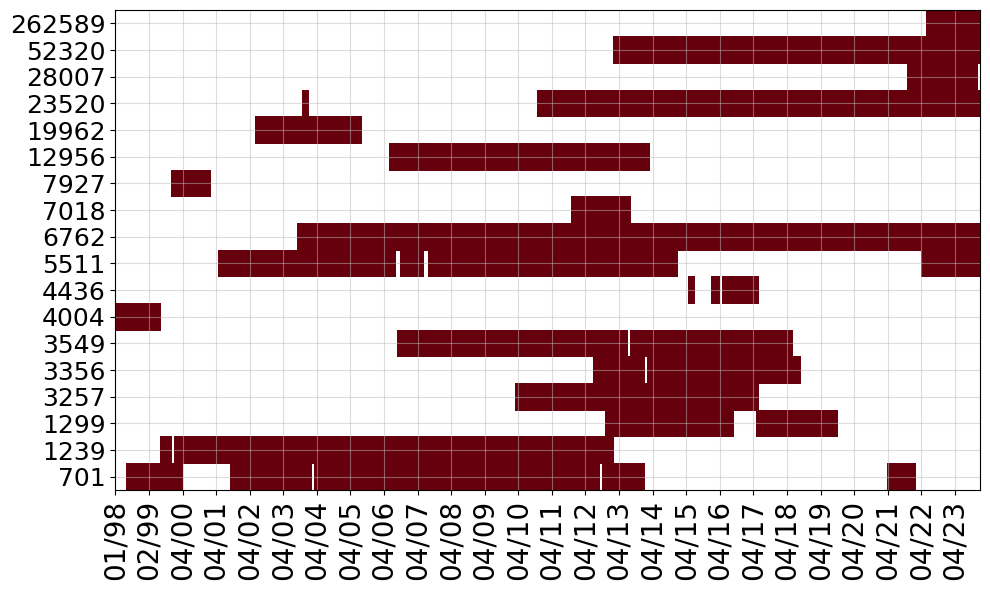

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 6))

ax.yaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")
ax.xaxis.grid(True, linestyle="-", color="#bababa", alpha=0.5, which="both")

# filtering
cantv_providers_df = cantv_providers_df.loc[
    cantv_providers_df["provider"].isin(prevalent_cantv_providers)
]

cantv_providers_df["p"] = np.ones(cantv_providers_df.shape[0])

p = cantv_providers_df.pivot(index="provider", columns="date")["p"]
t = p.columns
idx = p.index
p = p.to_numpy()

heatmap = ax.pcolor(
    p,
    norm=colors.Normalize(
        vmin=0,
        vmax=1,
    ),
    cmap="Reds",
    edgecolors="none",
)

ax.set_yticks(np.arange(len(idx)) + 0.5)
ax.set_yticklabels(fontsize=18, labels=idx)

i = np.arange(0, len(t), 1 * 12)

ax.set_xticks(i)
ax.set_xticklabels(
    fontsize=20, labels=[t[_i].strftime("%m/%y") for _i in i], rotation=90
)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/09-cantv_providers.pdf")

The ongoing crisis triggered tensions between the country and the United States, leading to economic sanctions that have reshaped Venezuela’s connectivity landscape.

This figure extends the analysis of CANTV’s upstream connectivity with a heatmap of the providers serving transit to CANTV for > 12 months since January 1998. This analysis reveals that Columbus Networks-AS23520 is the sole remaining US-based provider that continues to offer transit services to CANTV, following the departure of other US-based providers that started in 2013. Departures included Verizon-AS701, Sprint-AS1239, and AT&T-AS7018 in 2013, GTT (AS3257 and 4436) in 2017, and Level3 (briefly known as LUMEN and now as Cirion, AS3356, and AS3459) in 2018. During this period, Telefonica’s backbone unit Telxius-AS12959 and the Swedish-based Arelion-AS1299 also stopped serving CANTV.

Despite the departures mentioned, CANTV’s connectivity has been sustained in recent years by providers that existing submarine infrastructure reaching the shores of Venezuela. Notable among them is Telecom Italia-67672, a longstanding partner of CANTV, connecting through the South American Crossing (SAC) and Americas-II. Additionally, V.tal-AS52320 (formerly Brasil Telecom) utilizes the GlobeNet, while Orange-AS5511 (after a period of inactivity) and Columbus Networks-AS23520 leverage the Americas-II. A recent addition to this group of providers is Gold Data (AS28007 and AS394684), enhancing the diversity and stability of CANTV’s connectivity landscape.